In [1]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import random

C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

In [3]:
seed = 42
np.random.seed = seed

In [4]:
TRAIN_PATH = r'C:\Users\ADMIN\Desktop\Coastline Detection\Coastline-Detection-Summer-Project-master\ML Based\split-built\train'
TEST_PATH = r'C:\Users\ADMIN\Desktop\Coastline Detection\Coastline-Detection-Summer-Project-master\ML Based\split-built\test'
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print(train_ids)

['images', 'masks']


In [5]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [6]:
train_ids = next(os.walk(f"{TRAIN_PATH}/images"))[2]
test_ids = next(os.walk(f"{TEST_PATH}/images"))[2]

# Initialize X_train, Y_train, and X_test
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Resizing training images and masks
print('Processing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img_path = os.path.join(TRAIN_PATH, 'images', id_)
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img.astype(np.uint8)
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    mask_id = id_.replace('.tiff', '_mask.tiff')
    mask_path = os.path.join(TRAIN_PATH, 'masks', mask_id)
    mask_ = imread(mask_path)
    mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask_ = np.expand_dims(mask_, axis=-1)
    mask = np.maximum(mask, mask_).astype(bool)
    Y_train[n] = mask

# Processing test images
print('Processing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img_path = os.path.join(TEST_PATH, 'images', id_)
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img.astype(np.uint8)

print('Done!')

Processing training images and masks


  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [00:13<00:00,  8.27it/s]


Processing test images


100%|██████████| 47/47 [00:03<00:00, 12.08it/s]

Done!


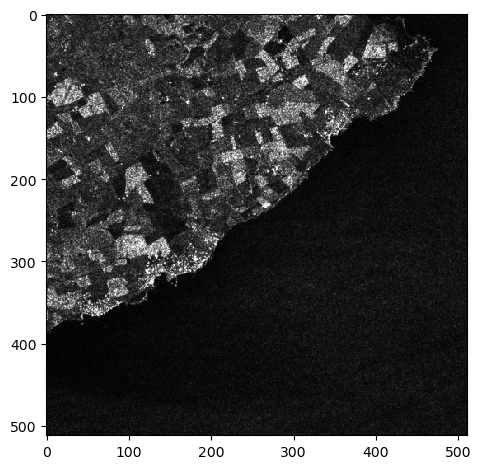

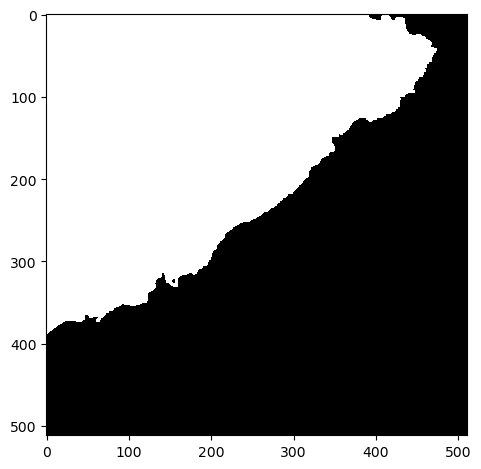

In [7]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [8]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
 kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
 kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(c5)
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(c9)
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [9]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 16  0           ['conv2d_1[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 256, 256, 32  4640        ['max_pooling2d[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, 256, 256, 32  0           ['conv2d_2[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_3 

In [10]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', 
verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.25, batch_size=16, epochs=25)
#results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
6/6 [==============================] - 31s 1s/step - loss: 0.6250 - accuracy: 0.5619 - val_loss: 0.5913 - val_accuracy: 0.5303
Epoch 2/25
6/6 [==============================] - 2s 392ms/step - loss: 0.5756 - accuracy: 0.6629 - val_loss: 0.5895 - val_accuracy: 0.6788
Epoch 3/25
6/6 [==============================] - 2s 394ms/step - loss: 0.5815 - accuracy: 0.7763 - val_loss: 0.5874 - val_accuracy: 0.7224
Epoch 4/25
6/6 [==============================] - 2s 379ms/step - loss: 0.5527 - accuracy: 0.7704 - val_loss: 0.5519 - val_accuracy: 0.7019
Epoch 5/25
6/6 [==============================] - 2s 393ms/step - loss: 0.5464 - accuracy: 0.7727 - val_loss: 0.5536 - val_accuracy: 0.7356
Epoch 6/25
6/6 [==============================] - 2s 401ms/step - loss: 0.5344 - accuracy: 0.8207 - val_loss: 0.5230 - val_accuracy: 0.7401
Epoch 7/25
6/6 [==============================] - 2s 391ms/step - loss: 0.4981 - accuracy: 0.8473 - val_loss: 0.4424 - val_accuracy: 0.7978
Epoch 8/25
6/6 [======

In [ ]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [11]:
model.save('UNet-built.h5')

1/1 [==============================] - 0s 146ms/step


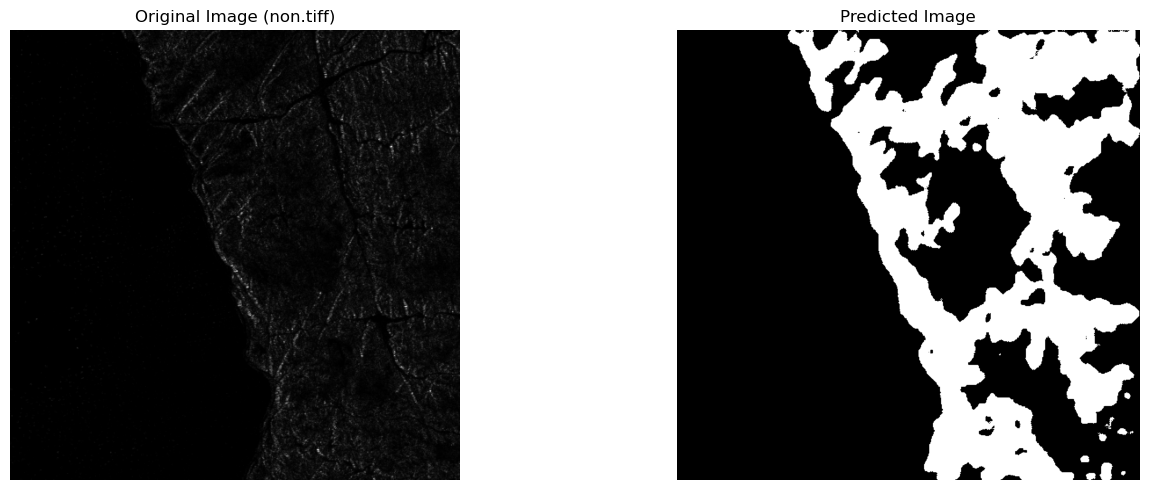

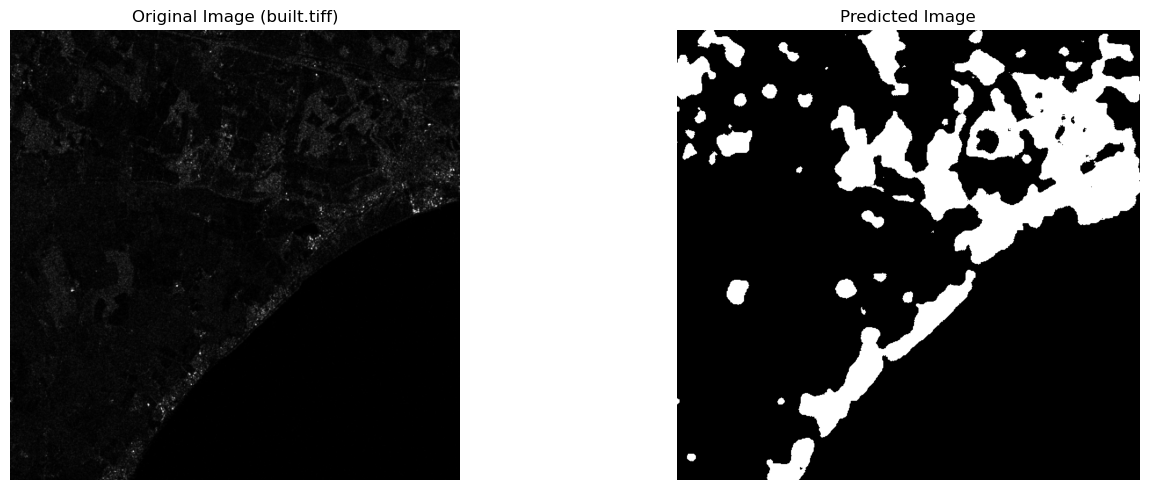

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from keras.models import load_model

# Model and image properties
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
model = load_model('UNetv3_2_25_epoch.h5')
images = ['non.tiff','built.tiff']

# Placeholder for inputs
X_test = np.zeros((len(images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for i in range(len(images)):
    # Read the original image
    img = imread(images[i])[:,:,:IMG_CHANNELS]
    original_size = img.shape[:2]  # Store original size for resizing later

    # Resize the image for the model
    img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[i] = img_resized  # Correct index to i instead of i-1

preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

for i in range(len(images)):
    # Resize the predicted image back to original size
    pred_image_resized = resize(np.squeeze(preds_test_t[i]), original_size, mode='constant', preserve_range=True)
    pred_image_resized = (pred_image_resized > 0.5).astype(np.uint8) * 255  # Threshold and scale back to 0-255

    # Plotting and saving the results
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(X_test[i])
    axs[0].title.set_text(f'Original Image ({images[i]})')
    axs[0].axis('off')
    axs[1].imshow(pred_image_resized, cmap='gray')
    axs[1].title.set_text('Predicted Image')
    axs[1].axis('off')
    plt.tight_layout()

    plt.savefig(f'VH-image-on-VV-Model-{i}.png')  # Save the plot first
    plt.show()  # Then display the plot


In [57]:
from PIL import Image
import numpy as np

def calculate_iou(image_path, mask_path):
    # Load image and mask
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Convert images to numpy arrays
    image_array = np.array(image)
    mask_array = np.array(mask)

    # Binarize images: pixels with value 255 become 1, others become 0
    image_array = np.where(image_array == 255, 1, 0)
    mask_array = np.where(mask_array == 255, 1, 0)

    # Calculate intersection and union
    intersection = np.logical_and(image_array, mask_array)
    union = np.logical_or(image_array, mask_array)

    # Calculate IoU
    iou = np.sum(intersection) / np.sum(union)

    return iou


a=[]
for i in range(1, 11):
    image_path = f"TestingDataIndianCoast\\TestingDataIndianCoast\\results\\{i}.tiff"
    mask_path = f"TestingDataIndianCoast\\TestingDataIndianCoast\\cropped\\{i}_mask.tiff"
    iou = calculate_iou(image_path, mask_path)
    a.append(iou)
    print(f"Image {i}: IoU = {iou}")
print(f"Average IoU = {sum(a)/len(a)}")


Image 1: IoU = 0.9139747619628906
Image 2: IoU = 0.9792088635897328
Image 3: IoU = 0.9357667096195865
Image 4: IoU = 0.45271164620768434
Image 5: IoU = 0.9712351777673965
Image 6: IoU = 0.9827702778842037
Image 7: IoU = 0.893344843427383
Image 8: IoU = 0.9474482371710584
Image 9: IoU = 0.9900077312444386
Image 10: IoU = 0.9538434842963734
Average IoU = 0.9020311733170748
